In [2]:
import pandas as pd
from path import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Data Preparation

In [3]:
file = Path('crypto_data.csv')

In [5]:
crypto_df = pd.read_csv(file, index_col=0)
crypto_df.head(10)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


In [21]:
# What mining algorithms are in use?
# this outputs a numpy array
# also, evidently I am bad at spelling "algorithm" so I'm just calling it "a_array" lol
a_array = crypto_df['Algorithm'].unique()
print(type(a_array))
print(a_array)
# another way to do this that outputs a python set instead of a numpy array: 
# a_set = set(crypto_df.Algorithm.values)

<class 'numpy.ndarray'>
['Scrypt' 'X11' 'SHA-256' 'X13' 'Ethash' 'CryptoNight-V7' 'Equihash'
 'SHA-512' 'Multiple' 'X15' 'NIST5' 'Quark' 'Groestl' 'PoS' 'NeoScrypt'
 'SHA3' 'HybridScryptHash256' 'Scrypt-n' 'PHI1612' 'Lyra2REv2'
 'CryptoNight' 'Shabal256' 'Counterparty' 'Blake' 'Momentum'
 'Stanford Folding' 'QuBit' 'XG Hash' 'M7 POW' 'Curve25519' 'Lyra2RE'
 'QUAIT' 'vDPOS' 'Blake2b' 'BLAKE256' '1GB AES Pattern Search' 'Dagger'
 'CryptoNight-Lite' 'X11GOST' 'ScryptOG' 'SHA-256D' 'POS 3.0'
 'Progressive-n' 'DPoS' 'Lyra2Z' 'X14' 'Time Travel' 'Argon2' 'Keccak'
 'Blake2S' 'Dagger-Hashimoto' '536' 'Argon2d' 'Cloverhash' 'Skein'
 'SkunkHash v2 Raptor' 'VeChainThor Authority' 'Ouroboros' 'POS 2.0'
 'SkunkHash' 'C11' 'Proof-of-BibleHash' 'SHA-256 + Hive'
 'Proof-of-Authority' 'XEVAN' 'VBFT' 'YescryptR16' 'IMesh' 'X16S'
 'Green Protocol' 'Semux BFT consensus' 'X16R' 'Tribus'
 'CryptoNight Heavy' 'Jump Consistent Hash' 'Wild Keccak' 'HMQ1725'
 'Zhash' 'Cryptonight-GPU' 'ECC 256K1' 'CryptoNight H

In [23]:
# print the counts of stocks being currently traded vs. not being currently traded 
crypto_df['IsTrading'].value_counts()

True     1144
False     108
Name: IsTrading, dtype: int64

In [180]:
# Select only cryptocurrencies that are being traded
# since the df itself will begin to change, I will put it into a new df called crypto_df_clean
crypto_df_clean = crypto_df[crypto_df['IsTrading'] == True]
# check to make sure the number True values in this column has not changed
crypto_df_clean['IsTrading'].value_counts()

True    1144
Name: IsTrading, dtype: int64

In [181]:
# Delete the IsTrading column; it is no longer necessary
crypto_df_clean = crypto_df_clean.drop(columns=['IsTrading'])
crypto_df_clean.head(2)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,41.999954,42
365,365Coin,X11,PoW/PoS,NaN,2300000000


In [182]:
# Delete all rows with null values
# print number of rows before and after to see how many are left
print(f'rows before dropping nulls: {crypto_df_clean.shape[0]}')
crypto_df_clean = crypto_df_clean.dropna(axis=0, how='any')
print(f' rows after dropping nulls: {crypto_df_clean.shape[0]}')

rows before dropping nulls: 1144
 rows after dropping nulls: 685


In [183]:
# Sort values in TotalCoinsMined to identify negative or zero values
crypto_df_clean.TotalCoinsMined.sort_values()

FIII   -5.917978e+09
LBTC    0.000000e+00
RIPO    0.000000e+00
BASH    0.000000e+00
CSH     0.000000e+00
            ...     
QWC     9.955311e+10
NYC     1.430067e+11
GCN     1.630551e+11
BCN     1.840668e+11
BTT     9.899887e+11
Name: TotalCoinsMined, Length: 685, dtype: float64

In [184]:
# looks like we have some zero and negative values
# Select only rows with positive TotalCoinsMined values
crypto_df_clean = crypto_df_clean[crypto_df_clean['TotalCoinsMined'] > 0]
print(f'remaining rows: {len(crypto_df_clean)}')

remaining rows: 532


In [185]:
# Delete the CoinName column from the original dataframe
crypto_df_clean = crypto_df_clean.drop(columns=['CoinName'])
crypto_df_clean.head(2)

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000


In [186]:
# Create dummy variables for columns with string values
# use pd.get_dummies() for one hot encoding
crypto_df_clean = pd.get_dummies(data=crypto_df_clean, columns=['ProofType', 'Algorithm'])
# how many columns were added? print out the df's new shape
print(f'rows:    {crypto_df_clean.shape[0]}\ncolumns: {crypto_df_clean.shape[1]}')
crypto_df_clean.head(4)

rows:    532
columns: 98


,TotalCoinsMined,TotalCoinSupply,ProofType_DPOS,ProofType_DPoS,ProofType_HPoW,ProofType_LPoS,ProofType_POBh,ProofType_PoA,ProofType_PoC,ProofType_PoS,...,Algorithm_Tribus,Algorithm_VBFT,Algorithm_VeChainThor Authority,Algorithm_X11,Algorithm_X11GOST,Algorithm_X13,Algorithm_X14,Algorithm_X15,Algorithm_X16R,Algorithm_XEVAN
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(crypto_df_clean)

In [188]:
# print the scaled data
x_scaled[0]

array([-0.11710817, -0.1528703 , -0.0433963 , -0.13118084, -0.0433963 ,
       -0.0433963 , -0.0433963 , -0.0433963 , -0.07530656, -0.43911856,
       -0.0433963 , -0.06142951, -0.0433963 , -0.0433963 , -0.89632016,
       -0.0433963 , -0.0433963 ,  1.42222617, -0.0433963 , -0.0433963 ,
       -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 ,
       -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 ,
       -0.06142951, -0.07530656, -0.0433963 , -0.06142951, -0.06142951,
       -0.0433963 , -0.0433963 , -0.19245009, -0.06142951, -0.09740465,
       -0.0433963 , -0.11547005, -0.07530656, -0.0433963 , -0.0433963 ,
       -0.15191091, -0.0433963 , -0.13118084, -0.0433963 , -0.0433963 ,
       -0.08703883, -0.0433963 , -0.0433963 , -0.0433963 , -0.0433963 ,
       -0.06142951, -0.0433963 , -0.08703883, -0.08703883, -0.08703883,
       -0.0433963 , -0.13118084, -0.13840913, -0.13840913, -0.0433963 ,
       -0.06142951, -0.0433963 , -0.07530656, -0.18168574, -0.04

In [189]:
# Identify the numbers of rows and columns in the scaled data
print(f'rows and columns in the scaled data:\nrows:    {x_scaled.shape[0]}\ncolumns: {x_scaled.shape[1]}')

rows and columns in the scaled data:
rows:    532
columns: 98


### Reduce dataset dimensions with PCA

In [190]:
# Reduce dimensions with PCA
# keep 90% of the features
pca = PCA(n_components=0.9)
prin_components = pca.fit_transform(x_scaled)
print(f'keep 90% of principal components\nremaining principal components: {prin_components.shape[1]}')

keep 90% of principal components
remaining principal components: 74


In [196]:
# The sum of the explained variance of the principal components
# I believe we want to keep 90% of the explained variance - have we done so?
variance_sum = pca.explained_variance_.sum()
(f'sum of explained variance: {variance_sum:.2f}')

'sum of explained variance: 88.47'

In [197]:
# Reduce dimensions with t-SNE
tsne = TSNE(perplexity=50)
tsne_features = tsne.fit_transform(prin_components)
print(f'after reducing dimensions with t-SNE\nremaining principal components (I think?): {tsne_features.shape[1]}')

/Users/randyweaver/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/randyweaver/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


after reducing dimensions with t-SNE
remaining principal components (I think?): 2


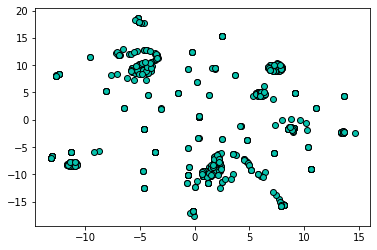

In [198]:
# Plot t-SNE output
x = tsne_features[:,0]
y = tsne_features[:,1]
plt.scatter(x, y, color='xkcd:turquoise', edgecolors='black')
plt.show()

In [199]:
# Identify clusters with k-means
inertia = []
k = [i for i in range(1,11)]
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(prin_components)
    inertia.append(kmeans.inertia_)
print(inertia)

[46979.075159676286, 45909.857192674914, 44654.76717691384, 43776.27420929284, 43052.153948317464, 41741.67775586482, 41311.43990938091, 40247.36348079568, 39591.852582045176, 38625.6153630754]


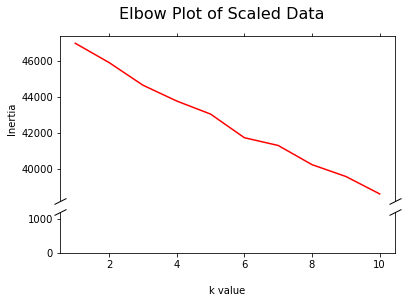

In [201]:
# Create an elbow plot
el_plot = pd.DataFrame({'K': k, 'inertia': inertia})

# plt.plot(el_plot['K'], el_plot['inertia'])
# I don't like when y axes don't start at zero and there is not a break to show it. I think this is a shortcoming of pyplot.
# I found the solution here: 
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=.1)  # adjust space between axes

# ax1 contains all the data, so I will not plot anything in ax2
ax1.plot(el_plot['K'], el_plot['inertia'], color='red')
# set ax2 y limits - I will just use 0 to 1200 with ticks at 0 and 1000 
# This is hardcoded since I know the scale should be in 1000's, but I think that's ok here
ax2.set_ylim(0, 1200)
ax2_yticks = [0, 1000]
ax2.set_yticks(ax2_yticks)

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# create the "cut-out" lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# much better. 

fig.suptitle('Elbow Plot of Scaled Data', fontsize=16)
ax1.set_ylabel('Inertia')
plt.xlabel('\nk value')
plt.show()

## Recommendation
I don't believe there is any meaningful way to cluster these data. Another way to put this is that there was pretty much one big cluster which can't be further divided. The cryptos cannot be classified using the information given. 